In [28]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
import category_encoders as ce

do basic regression so perform standard preprocessing

In [51]:
test_path = 'dataset/fraudTest.csv'
train_path = 'dataset/fraudTrain.csv'
df_train = pd.read_csv(train_path, dtype_backend = "pyarrow")
df_test = pd.read_csv(test_path, dtype_backend = "pyarrow")

In [52]:
df_train["cc_num"] = df_train["cc_num"].astype(str)
df_train["amt_boxcox"], fitted_lambda = stats.boxcox(df_train["amt"])
df_train["city_pop_boxcox"], fitted_lambda_city = stats.boxcox(df_train["amt"])

In [53]:
df_test["cc_num"] = df_test["cc_num"].astype(str)
df_test["amt_boxcox"] = stats.boxcox(df_test["amt"], lmbda=fitted_lambda)
df_test["city_pop_boxcox"] = stats.boxcox(df_test["amt"], lmbda=fitted_lambda_city)

In [54]:
df_train_new = df_train[["trans_date_trans_time", "cc_num", "merchant", "category", "amt_boxcox",
                          "gender", "street", "city", "state", "zip", "lat", "long", "city_pop_boxcox", "job", "dob", "unix_time", "merch_lat", "merch_long", "is_fraud"]]

In [55]:
df_test_new = df_test[["trans_date_trans_time", "cc_num", "merchant", "category", "amt_boxcox",
                       "gender", "street", "city", "state", "zip", "lat", "long",
                       "city_pop_boxcox", "job", "dob", "unix_time", "merch_lat", "merch_long","is_fraud"]]

In [56]:
X = df_train_new.drop(columns = "is_fraud")
y = df_train_new["is_fraud"]

In [57]:
X_test = df_test_new.drop(columns="is_fraud").copy()
y_test = df_test_new["is_fraud"].copy()

Consider encoding categorical variables - merchant, category, gender, job, 
Could remove street city state and zip for now

In [42]:
X["age"] = (pd.to_datetime(X["trans_date_trans_time"]) - pd.to_datetime(X["dob"])).dt.days // 365
X_test["age"] = (pd.to_datetime(X_test["trans_date_trans_time"]) - pd.to_datetime(X_test["dob"])).dt.days // 365

In [58]:
X_dropped = X.drop(columns=["trans_date_trans_time","cc_num","street","city","state","zip","dob"])

In [59]:
X_test_dropped = X_test.drop(columns=["trans_date_trans_time", "cc_num", "street", "city", "state", "zip", "dob"])

Now to perform the encoding

In [60]:
encodings = ["merchant", "category", "gender", "job"]
# Copy the original DataFrame
X_be = X_dropped.copy()

# Apply binary or label encoding as appropriate
binary_encoder_cols = []
for col in encodings:
    if X_be[col].nunique() <= 2:
        le = preprocessing.LabelEncoder()
        X_be[col] = le.fit_transform(X_be[col])
    else:
        binary_encoder_cols.append(col)

# Apply binary encoding to columns with more than 2 categories
if binary_encoder_cols:
    be = ce.BinaryEncoder(cols=binary_encoder_cols)
    X_be = be.fit_transform(X_be)

In [61]:
X_test_be = X_test_dropped.copy()

# Reuse the same `le` and `be` used earlier in training
for col in encodings:
    if X_test_be[col].nunique() <= 2:
        # This assumes you saved the LabelEncoder from train, e.g., le_gender = ...
        le = preprocessing.LabelEncoder()
        le.fit(X[col])  # Fit on training data
        X_test_be[col] = le.transform(X_test_be[col])
    else:
        # Nothing here, BinaryEncoder will handle it next
        pass

# Apply BinaryEncoder fitted on train data
X_test_be = be.transform(X_test_be)  # 'be' must be the fitted BinaryEncoder from train

Implement PCA after

# ML models to use

LDA for dimensionality reduction:
- standardization
- SMOTE to address class imbalance
- apply LDA
Could implement PCA


XGBoost, 

MLP, DistilBERT, 

In [17]:
y

0          0
1          0
2          0
3          0
4          0
          ..
1296670    0
1296671    0
1296672    0
1296673    0
1296674    0
Name: is_fraud, Length: 1296675, dtype: int64[pyarrow]

To deal with imbalanced classes
Resampling - oversampling minority class 
cost-sensitive learning - modify loss of model to give more weights to minority class
Ensemble methods - boosting
Thresholding
GANs - used to generate synthetic examples of the minority class

Implementing XGBoost

In [33]:
import xgboost as xgb

In [62]:
xgbc = xgb.XGBClassifier(n_jobs=4, max_depth=10, min_samples_leaf=0.001, 
                         learning_rate=0.1, n_estimators=100, eval_metric="auc")
xgbc.fit(X_be, y)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:05:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, min_samples_leaf=0.001,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=100, n_jobs=4, ...)

In [69]:
y_test

0         0
1         0
2         0
3         0
4         0
         ..
555714    0
555715    0
555716    0
555717    0
555718    0
Name: is_fraud, Length: 555719, dtype: int64[pyarrow]

Verifying results

In [73]:
from sklearn.metrics import precision_recall_curve, f1_score

In [ ]:
predictions = xgbc.predict_proba(X_test_be)[:,1]
pred = pd.DataFrame({"isFraud" : predictions})


array([2.4383437e-05, 6.0470589e-04, 1.8262568e-05, ..., 9.7177681e-06,
       1.5490834e-03, 3.4245229e-05], dtype=float32)

In [74]:
y_probs = pred["isFraud"].values
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8) 
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

In [76]:
best_threshold

0.25349018

In [77]:
import matplotlib.pyplot as plt

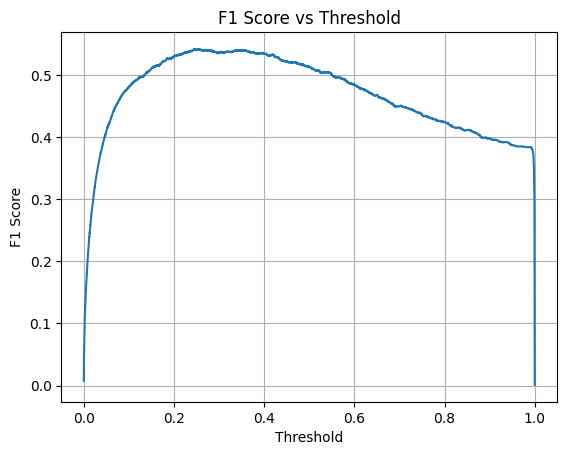

In [ ]:
plt.plot(thresholds, f1_scores[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid()
plt.show()

In [84]:
sum((y_test == 1) == (y_probs > best_threshold))/len(y_test.values)

0.9958954075710926

In [87]:
from sklearn.metrics import average_precision_score

average_precision_score(y_test, y_probs)

0.58149645696742

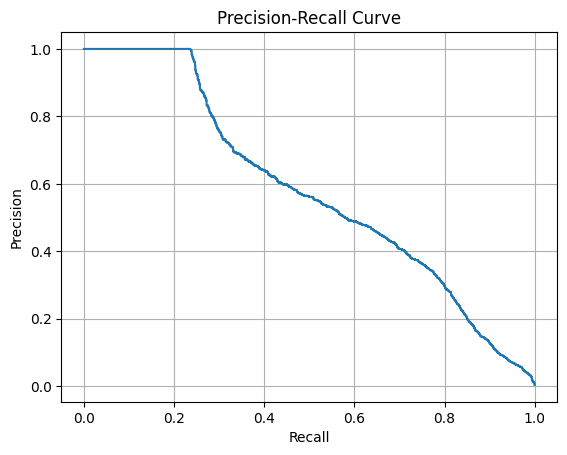

In [89]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

Tuning parameters

In [90]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
param_test1 = {'n_estimators': [100], 'learning_rate':[0.01, 0.1, 1]}
gbm_tune1 = GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=0.001, max_depth=4)

gs1 = GridSearchCV(estimator=gbm_tune1, param_grid=param_test1, scoring='roc_auc', n_jobs=6, cv=5)

In [93]:
gs1.fit(X_be, y)

KeyboardInterrupt: 

We want precision recall curve